In [10]:
# === BIBLIOTECAS NECESS√ÅRIAS ===
# Manipula√ß√£o de dados e c√°lculos num√©ricos
import pandas as pd 
import numpy as np  
# Visualiza√ß√£o est√°tica (gr√°ficos tradicionais)
import matplotlib.pyplot as plt 
import seaborn as sns            
# Manipula√ß√£o de datas
from datetime import datetime  
# Visualiza√ß√£o interativa e din√¢mica
import plotly.express as px     
import plotly.graph_objects as go 
from plotly.subplots import make_subplots 
# Manipula√ß√£o de arquivos e sistemas
import glob
import os  
# Express√µes regulares
import re 

In [3]:
# 1) Carregar e concatenar os dados dos processos judiciais da pasta uploads
# Exibi√ß√£o no console
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 200)

# Listar os arquivos CSV na pasta 'uploads'
arquivos_csv = glob.glob('uploads/processos_*.csv')

# Carregar os arquivos CSV e concatenar em um √∫nico DataFrame
dfs = []
tamanho_total_bytes = 0   # Somar os tamanhos dos arquivos
for arquivo in arquivos_csv:
    # Extrair o ano do nome do arquivo
    ano = int(arquivo.split('_')[-1].split('.')[0])
    
    # Soma o tamanho de cada arquivo √† vari√°vel
    tamanho_total_bytes += os.path.getsize(arquivo)
    
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    df_ano['ano_arquivo'] = ano  # Adicionar coluna com o ano do arquivo
    dfs.append(df_ano)

print("\n=== Arquivo carregado com sucesso! ===")
df_juridico = pd.concat(dfs, ignore_index=True)
print("Dimens√µes (linhas, colunas):", df_juridico.shape)

# Tamanho do arquivo
file_size_mb = tamanho_total_bytes / (1024**2)
print(f"Tamanho total dos arquivos CSV no disco: {file_size_mb:.2f} MB")

# Verifica√ß√£o de valores vazios ou nulos no DataFrame df_juridico
print("\n=== Verifica√ß√£o de Valores Nulos/Vazios ===")

# Contar o total de valores nulos por coluna
valores_nulos_por_coluna = df_juridico.isnull().sum()

# Filtrar para mostrar apenas as colunas que de fato cont√™m valores nulos
colunas_com_nulos = valores_nulos_por_coluna[valores_nulos_por_coluna > 0]

if colunas_com_nulos.empty:
    print("N√£o foram encontrados valores nulos ou vazios no DataFrame.")
else:
    print("Foram encontrados valores nulos nas seguintes colunas:")
    
    # Criar um DataFrame de resumo para uma visualiza√ß√£o clara
    total_registros = len(df_juridico)
    df_resumo_nulos = pd.DataFrame({
        'Qtd Nulos': colunas_com_nulos,
        'Percentual (%)': (colunas_com_nulos / total_registros) * 100
    })
    
    # Ordenar o resultado pela coluna de percentual, do maior para o menor
    df_resumo_nulos_sorted = df_resumo_nulos.sort_values(by='Percentual (%)', ascending=False)
    
    # Formatar a coluna de percentual para exibir com duas casas decimais e o s√≠mbolo '%'
    df_resumo_nulos_sorted['Percentual (%)'] = df_resumo_nulos_sorted['Percentual (%)'].map('{:.2f}%'.format)
    
    # Exibir a tabela-resumo
    print(df_resumo_nulos_sorted)

# Guardar uma c√≥pia de trabalho
df = df_juridico.copy()


=== Arquivo carregado com sucesso! ===
Dimens√µes (linhas, colunas): (4944351, 11)
Tamanho total dos arquivos CSV no disco: 726.09 MB

=== Verifica√ß√£o de Valores Nulos/Vazios ===
Foram encontrados valores nulos nas seguintes colunas:
             Qtd Nulos Percentual (%)
data_baixa     1749238         35.38%
codg_classe          2          0.00%


In [4]:
# 2) Tratamento dos Dados para Advogados
# Tratamento das colunas
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['ano_distribuicao'] = df['data_distribuicao'].dt.year # Criar coluna de ano de distribui√ß√£o
df['is_segredo_justica'] = df['is_segredo_justica'].astype(bool)

# Tratamento dos n√∫meros de OAB
def is_oab_valida(oab):
    """
    Verifica se um n√∫mero de OAB √© v√°lido seguindo o formato:
    N√öMEROS + LETRA + ESPA√áO + UF. Ex: '2153421N GO'
    """
    if not isinstance(oab, str) or not oab.strip():
        return False
    oab_limpa = oab.upper().strip()
    ufs_validas = ['GO', 'DF', 'SP', 'RJ', 'MG', 'RS', 'SC', 'PR', 'BA', 'PE',
                  'CE', 'MA', 'ES', 'AL', 'SE', 'PB', 'RN', 'PI', 'MT', 'MS', 
                  'TO', 'PA', 'AP', 'AM', 'RR', 'AC', 'RO'
                  ]
    padrao_regex = re.compile(f"^[1-9]\\d*[A-Z]\\s({'|'.join(ufs_validas)})$")
    return bool(padrao_regex.match(oab_limpa))

# Aplicar a valida√ß√£o de OAB
df['oab_valida'] = df['oab'].apply(is_oab_valida)

# Contar e exibir a quantidade de OABs inv√°lidas
registros_invalidos = df[df['oab_valida'] == False]
qtd_invalidos = len(registros_invalidos)

print("\n=== Valida√ß√£o de Registros de OAB ===")
print(f"Total de registros com OAB em formato inv√°lido ou nulo: {qtd_invalidos}")

if qtd_invalidos > 0:
    exemplos_invalidos = registros_invalidos['oab'].unique()
    print(f"Exemplos de OABs inv√°lidas: {exemplos_invalidos}")
print("\n" + "="*100 + "\n")

# Dataframe com apenas OABs v√°lidas
df_validos = df[df['oab_valida'] == True].copy()

# Verificar se valores NULL ou Vazios

print("\n=== Dataframe com apenas OAB's v√°lidas ===")
display(df_validos.head())


=== Valida√ß√£o de Registros de OAB ===
Total de registros com OAB em formato inv√°lido ou nulo: 20335
Exemplos de OABs inv√°lidas: ['GO' '0A RJ' '0A MT' '0S GO' '0A MG' '0S MT' '0S DF' '0S MA' '0A PE' 'TO'
 '0A MS' '0S AL' '0S CE' '0S SC' '0S MG' '0S MS' '0S RS' '0S RN' '0A TO'
 '0A SE' '0S PE' '0A RS' '0S TO']



=== Dataframe com apenas OAB's v√°lidas ===


processo data_distribuicao  data_baixa entrancia  comarca       serventia  is_segredo_justica  codg_classe         oab  codg_assunto  ano_arquivo  ano_distribuicao  oab_valida
0  0119071.75.2004.8.09.0051        2022-05-25  2022-06-30     FINAL  GOI√ÇNIA   2¬™ Vara C√≠vel               False          7.0   19365N GO         10671         2022              2022        True
1  0189657.40.2004.8.09.0051        2022-06-02  2024-01-22     FINAL  GOI√ÇNIA  31¬™ Vara C√≠vel               False          7.0   10647N GO         10671         2022              2022        True
2  0189657.40.2004.8.09.0051        2022-06-02  2024-01-22     FINAL  GOI√ÇNIA  31¬™ Vara C√≠vel               False          7.0  167974A SP         10671         2022              2022        True
3  0189657.40.2004.8.09.0051        2022-06-02  2024-01-22     FINAL  GOI√ÇNIA  31¬™ Vara C√≠vel               False          7.0   20763N GO         10671         2022              2022        True
4  0197944.89.2004.8.09.0051        2022-06-07  2022-10-07     FINAL  GOI√ÇNIA  22¬™ Vara C√≠vel               False          7.0   20785N GO         10671         2022              2022        True

In [5]:
# 3) An√°lise de Processos Sigilosos e N√£o Sigilosos por OAB v√°lida
# Agrupar por 'oab' e 'is_segredo_justica' e contar a quantidade de processos
df_analise = df_validos.groupby(['oab', 'is_segredo_justica']).size().reset_index(name='qtd_processos')

# Ordenar os resultados para melhor visualiza√ß√£o (pela OAB e depois pela quantidade)
df_analise_sorted = df_analise.sort_values(by=['oab', 'qtd_processos'], ascending=[True, False])

print("\n=== Tabela de Processos Sigilosos e N√£o Sigilosos por OAB ===")
display(df_analise_sorted.head(10))

# Para uma visualiza√ß√£o mais clara, "pivotei" a tabela
# Criando colunas separadas para processos sigilosos e n√£o sigilosos
df_pivot = df_analise.pivot_table(
    index='oab',
    columns='is_segredo_justica',
    values='qtd_processos',
    fill_value=0 # Preenche com 0 OABs que n√£o t√™m um dos tipos
)

# Renomear as colunas (False -> nao_sigilosos, True -> sigilosos)
df_pivot = df_pivot.rename(columns={False: 'nao_sigilosos', True: 'sigilosos'})

# Adicionar uma coluna de total e ordenar pelos advogados com mais processos
df_pivot['total_processos'] = df_pivot['nao_sigilosos'] + df_pivot['sigilosos']
df_pivot_sorted = df_pivot.sort_values(by='total_processos', ascending=False)


print("\n=== Tabela Pivotada: Contagem por OAB ===")
display(df_pivot_sorted.head(10))


=== Tabela de Processos Sigilosos e N√£o Sigilosos por OAB ===


oab  is_segredo_justica  qtd_processos
0  100005A PR               False              8
1  100006A PR               False              2
2  100006S RS               False             17
3  100008A RJ                True              1
4   10000N GO               False             16
5  100018A RS               False              1
6   10001A DF               False              1
7   10001A MS               False              1
8   10001A TO               False              1
9   10001N GO               False             58


=== Tabela Pivotada: Contagem por OAB ===


is_segredo_justica  nao_sigilosos  sigilosos  total_processos
oab                                                          
16315N GO                 86839.0      439.0          87278.0
21735N GO                 71783.0     1548.0          73331.0
40240N GO                 69514.0     1239.0          70753.0
38664N GO                 43965.0     3617.0          47582.0
36056N GO                 29732.0      518.0          30250.0
28449A GO                 28525.0      683.0          29208.0
9632N GO                  28435.0        4.0          28439.0
19417N GO                 28226.0        3.0          28229.0
31989N GO                 25473.0      232.0          25705.0
31279N GO                 22162.0       89.0          22251.0

In [ ]:
# 4) C√°lculo de Estat√≠sticas Descritivas (Medidas de Tend√™ncia Central)
print("=== ESTAT√çSTICAS DESCRITIVAS DE PROCESSOS POR OAB V√ÅLIDA ===")

# An√°lise Geral (Total de Processos)
# Distribui√ß√£o do n√∫mero total de processos por advogado.
print("--- An√°lise Geral (Total de Processos por OAB) ---")
total_counts = df_pivot_sorted['total_processos']

# C√°lculo das m√©tricas
media_geral = total_counts.mean()
mediana_geral = total_counts.median()
moda_geral = total_counts.mode()

print(f"M√©dia de processos por OAB: {media_geral:.2f}")
print(f"Mediana de processos por OAB: {mediana_geral}")
# A moda pode retornar m√∫ltiplos valores se houver empate; pegamos o primeiro.
if not moda_geral.empty:
    print(f"Moda de processos por OAB: {moda_geral.iloc[0]}")
else:
    print("Moda: N√£o h√° um valor √∫nico que seja o mais frequente.")


# An√°lise de Processos N√ÉO SIGILOSOS
# Foco na distribui√ß√£o de processos p√∫blicos por advogado.
print("\n--- An√°lise de Processos N√ÉO SIGILOSOS por OAB ---")
nao_sigilosos_counts = df_pivot_sorted['nao_sigilosos']

# C√°lculo das m√©tricas
media_nao_sigilosos = nao_sigilosos_counts.mean()
mediana_nao_sigilosos = nao_sigilosos_counts.median()
moda_nao_sigilosos = nao_sigilosos_counts.mode()

print(f"M√©dia de processos n√£o sigilosos por OAB: {media_nao_sigilosos:.2f}")
print(f"Mediana de processos n√£o sigilosos por OAB: {mediana_nao_sigilosos}")
if not moda_nao_sigilosos.empty:
    print(f"Moda de processos n√£o sigilosos por OAB: {moda_nao_sigilosos.iloc[0]}")
else:
    print("Moda: N√£o h√° um valor √∫nico que seja o mais frequente.")


# An√°lise de Processos SIGILOSOS
# Foco na distribui√ß√£o de processos em segredo de justi√ßa por advogado.
print("\n--- An√°lise de Processos SIGILOSOS por OAB ---")
sigilosos_counts = df_pivot_sorted['sigilosos']

# C√°lculo das m√©tricas
media_sigilosos = sigilosos_counts.mean()
mediana_sigilosos = sigilosos_counts.median()
moda_sigilosos = sigilosos_counts.mode()

print(f"M√©dia de processos sigilosos por OAB: {media_sigilosos:.2f}")
print(f"Mediana de processos sigilosos por OAB: {mediana_sigilosos}")
if not moda_sigilosos.empty:
    print(f"Moda de processos sigilosos por OAB: {moda_sigilosos.iloc[0]}")
else:
    print("Moda: N√£o h√° um valor √∫nico que seja o mais frequente.")
print("\n" + "="*100 + "\n")

=== ESTAT√çSTICAS DESCRITIVAS DE PROCESSOS POR OAB V√ÅLIDA ===
--- An√°lise Geral (Total de Processos por OAB) ---
M√©dia de processos por OAB: 43.27
Mediana de processos por OAB: 3.0
Moda de processos por OAB: 1.0

--- An√°lise de Processos N√ÉO SIGILOSOS por OAB ---
M√©dia de processos n√£o sigilosos por OAB: 36.71
Mediana de processos n√£o sigilosos por OAB: 3.0
Moda de processos n√£o sigilosos por OAB: 1.0

--- An√°lise de Processos SIGILOSOS por OAB ---
M√©dia de processos sigilosos por OAB: 6.56
Mediana de processos sigilosos por OAB: 0.0
Moda de processos sigilosos por OAB: 0.0





=== VISUALIZA√á√ÉO GR√ÅFICA DAS ESTAT√çSTICAS ===



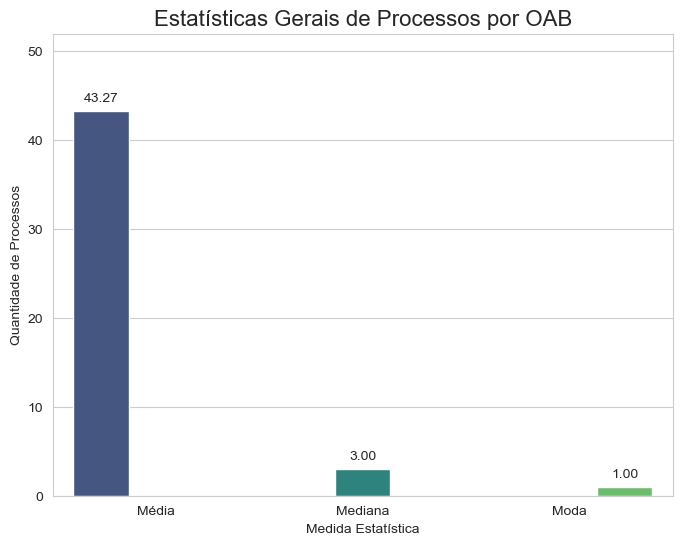

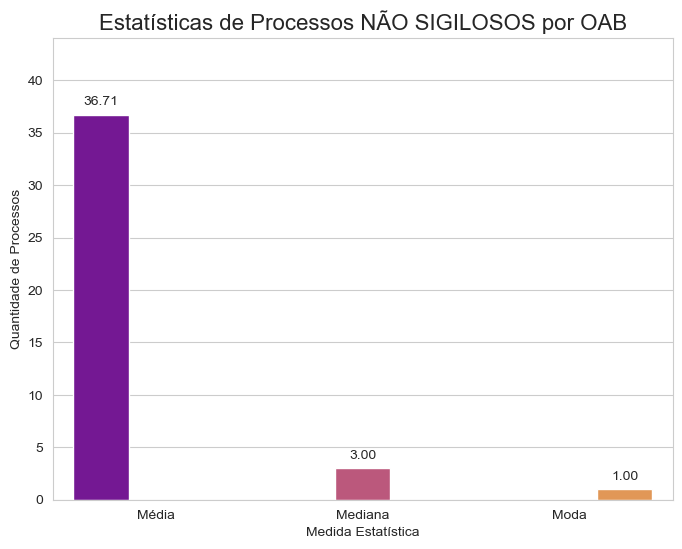

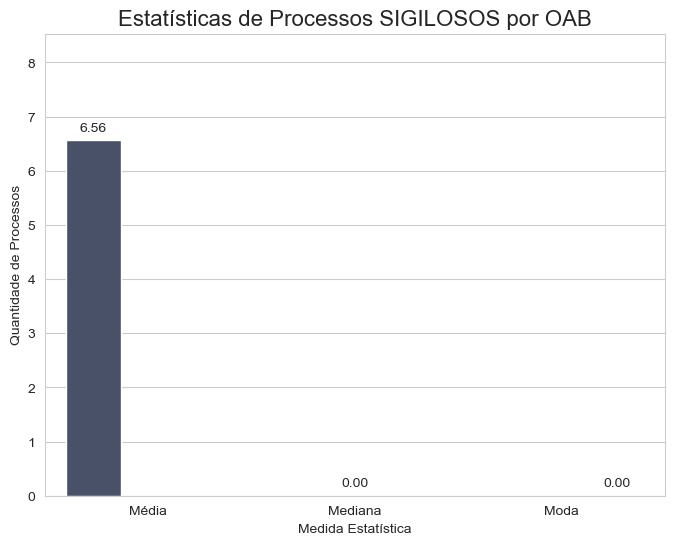

In [14]:
# 5) Visualiza√ß√£o Gr√°fica das Estat√≠sticas
# Configurar um estilo est√©tico para os gr√°ficos
sns.set_style("whitegrid")
# A paleta de cores ser√° definida dentro de cada gr√°fico

print("\n" + "="*100)
print("=== VISUALIZA√á√ÉO GR√ÅFICA DAS ESTAT√çSTICAS ===")
print("="*100 + "\n")

# --- 5.1) Gr√°fico para An√°lise Geral ---

# Preparar os dados para o gr√°fico
dados_geral = {
    'M√©trica': ['M√©dia', 'Mediana', 'Moda'],
    'Valor': [media_geral, mediana_geral, moda_geral.iloc[0] if not moda_geral.empty else 0]
}
df_plot_geral = pd.DataFrame(dados_geral)

# Criar o gr√°fico
plt.figure(figsize=(8, 6))
ax_geral = sns.barplot(x='M√©trica', y='Valor', data=df_plot_geral, palette='viridis', hue='M√©trica')

ax_geral.get_legend().remove()

# Adicionar o valor exato no topo de cada coluna
for p in ax_geral.patches:
    ax_geral.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.title('Estat√≠sticas Gerais de Processos por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estat√≠stica')
plt.ylim(0, media_geral * 1.2)
plt.show()


# --- 5.2) Gr√°fico para Processos N√ÉO SIGILOSOS ---

# Preparar os dados para o gr√°fico
dados_nao_sigilosos = {
    'M√©trica': ['M√©dia', 'Mediana', 'Moda'],
    'Valor': [media_nao_sigilosos, mediana_nao_sigilosos, moda_nao_sigilosos.iloc[0] if not moda_nao_sigilosos.empty else 0]
}
df_plot_nao_sigilosos = pd.DataFrame(dados_nao_sigilosos)

# Criar o gr√°fico
plt.figure(figsize=(8, 6))
ax_nao_sigiloso = sns.barplot(x='M√©trica', y='Valor', data=df_plot_nao_sigilosos, palette='plasma', hue='M√©trica')

ax_nao_sigiloso.get_legend().remove()

# Adicionar o valor exato no topo de cada coluna
for p in ax_nao_sigiloso.patches:
    ax_nao_sigiloso.annotate(f'{p.get_height():.2f}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')

plt.title('Estat√≠sticas de Processos N√ÉO SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estat√≠stica')
plt.ylim(0, media_nao_sigilosos * 1.2)
plt.show()


# --- 5.3) Gr√°fico para Processos SIGILOSOS ---

# Preparar os dados para o gr√°fico
dados_sigilosos = {
    'M√©trica': ['M√©dia', 'Mediana', 'Moda'],
    'Valor': [media_sigilosos, mediana_sigilosos, moda_sigilosos.iloc[0] if not moda_sigilosos.empty else 0]
}
df_plot_sigilosos = pd.DataFrame(dados_sigilosos)

# Criar o gr√°fico
plt.figure(figsize=(8, 6))
ax_sigiloso = sns.barplot(x='M√©trica', y='Valor', data=df_plot_sigilosos, palette='cividis', hue='M√©trica')

ax_sigiloso.get_legend().remove()

# Adicionar o valor exato no topo de cada coluna
for p in ax_sigiloso.patches:
    ax_sigiloso.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

plt.title('Estat√≠sticas de Processos SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estat√≠stica')
plt.ylim(0, media_sigilosos * 1.3)
plt.show()

# üìä An√°lise Interpretativa dos Resultados Estat√≠sticos (M√©dia, Mediana e Moda)

## üí° Interpreta√ß√£o Geral

A conclus√£o mais importante, que √© vista nos tr√™s casos, √© a exist√™ncia de uma **distribui√ß√£o de processos extremamente assim√©trica e desigual**. Em outras palavras, h√° uma concentra√ß√£o massiva de processos em um n√∫mero relativamente pequeno de advogados, enquanto a grande maioria dos advogados atua em pouqu√≠ssimos casos.

Esse fen√¥meno √© claramente indicado pela **enorme diferen√ßa entre a M√âDIA e a MEDIANA/MODA**.

- A **M√©dia** √© muito sens√≠vel a valores extremos (outliers).
- A **Mediana** e a **Moda** representam melhor o advogado "t√≠pico" ou o cen√°rio "mais comum".

> Quando a m√©dia √© muito maior que a mediana, como √© o caso, isso significa que existem alguns "pontos fora da curva" com valores alt√≠ssimos que est√£o "puxando" a m√©dia para cima.

---

## üîé An√°lise Detalhada dos Resultados

### ‚öñÔ∏è 1. An√°lise Geral (Total de Processos por OAB)

* **‚≠ê Moda de 1.0:** O n√∫mero de processos que mais se repete entre os advogados √© apenas **1**, ou seja, o cen√°rio mais comum √© um advogado ter um √∫nico processo.
* **‚ÜîÔ∏è Mediana de 3.0:** Se organizarmos todos os advogados em uma fila, do que tem menos processos para o que tem mais (ordem crescente), o advogado que est√° exatamente no meio da fila tem **3 processos**. Isso significa que **metade de todos os advogados tem 3 processos ou menos**.
* **üßÆ M√©dia de 43.27:** Embora o advogado t√≠pico tenha apenas 3 processos, a m√©dia geral √© de 43. Isso √© causado por um grupo seleto de advogados (provavelmente grandes escrit√≥rios ou especialistas em contencioso de massa) que possuem centenas ou milhares de processos, inflando drasticamente a m√©dia.

> **Conclus√£o:** Portanto, conforme os dados, √© poss√≠vel notar que o advogado t√≠pico tem poucos casos, mas uma minoria concentra a maior parte dos processos.

### üìñ 2. An√°lise de Processos N√ÉO SIGILOSOS por OAB

* **‚≠ê Moda de 1.0 e ‚ÜîÔ∏è Mediana de 3.0:** O padr√£o se repete. O advogado t√≠pico tamb√©m tem entre 1 e 3 processos que n√£o s√£o sigilosos.
* **üßÆ M√©dia de 36.71:** Este valor √© alto e pr√≥ximo da m√©dia geral (43.27).

> **Conclus√£o:** A grande desigualdade que vemos na an√°lise geral √© **majoritariamente impulsionada pelos processos n√£o sigilosos**. Isso faz sentido, pois √°reas que geram alto volume de casos, como direito do consumidor ou tribut√°rio, geralmente n√£o correm em segredo de justi√ßa.

### üîí 3. An√°lise de Processos SIGILOSOS por OAB

Esta √© a an√°lise mais reveladora sobre especializa√ß√£o.

* **‚≠ê Moda de 0.0:** O cen√°rio mais comum √© um advogado ter **nenhum processo sigiloso**.
* **‚ÜîÔ∏è Mediana de 0.0:** **Pelo menos metade de todos os advogados n√£o tem um √∫nico processo sigiloso**. Isso refor√ßa a ideia de que a atua√ß√£o em casos sigilosos n√£o √© a norma.
* **üßÆ M√©dia de 6.56:** Este √© o ponto crucial. Mesmo que a maioria n√£o tenha nenhum processo sigiloso, a m√©dia √© positiva. Isso significa que a minoria de advogados que **atua** com processos sigilosos (√°reas como direito de fam√≠lia, criminal, etc.) tende a ter um n√∫mero relevante desses processos.

> **Conclus√£o:** A atua√ß√£o em processos que correm em segredo de justi√ßa parece ser um **nicho de especializa√ß√£o**. A maioria dos advogados n√£o atua nessa √°rea, mas aqueles que atuam o fazem com uma frequ√™ncia que se destaca.

---

## üèÜ Resumo das Descobertas (Insights)

1.  **üéØ Atua√ß√£o Concentrada:** Os dados n√£o mostram uma distribui√ß√£o equilibrada de trabalho. Um pequeno percentual de advogados/escrit√≥rios domina o volume de processos.
2.  **üë§ O Advogado "T√≠pico" vs. a M√©dia:** O advogado "comum" tem entre 1 e 3 processos. A m√©dia de 43 √© uma ilus√£o estat√≠stica criada por outliers e n√£o representa a realidade da maioria.
3.  **üöÄA Atua√ß√£o em A√ß√µes Repetitivas √© a Chave da Desigualdade:** O alto volume de processos est√° concentrado em casos p√∫blicos (n√£o sigilosos), sugerindo atua√ß√£o em advocacia de massa.
4.  **üíº Segredo de Justi√ßa como Especialidade:** Atuar em processos sigilosos √© para um grupo espec√≠fico de advogados. A maioria n√£o tem contato com essa √°rea, indicando uma clara divis√£o de especialidades.


=== VISUALIZA√á√ÉO DA DISTRIBUI√á√ÉO COM BOXPLOTS ===

--- 6.1) An√°lise Geral: Total de Processos por OAB ---
Primeiro, a visualiza√ß√£o completa para entendermos a escala dos outliers...


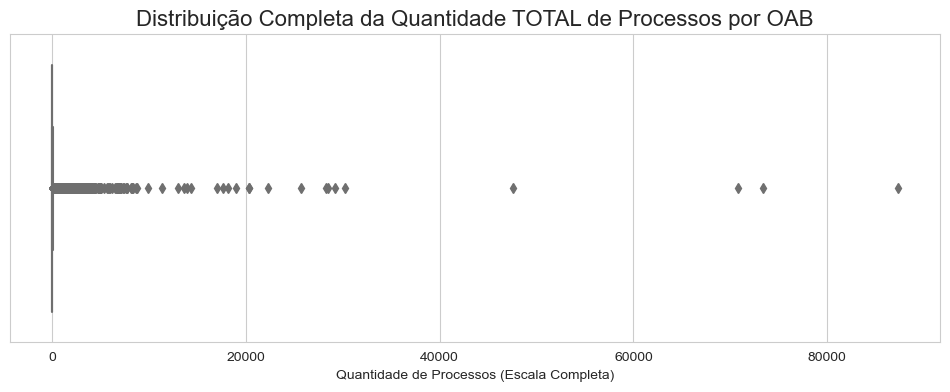


Agora, um zoom na distribui√ß√£o, focando nos 95% dos advogados com menos processos (at√© 153 processos)...


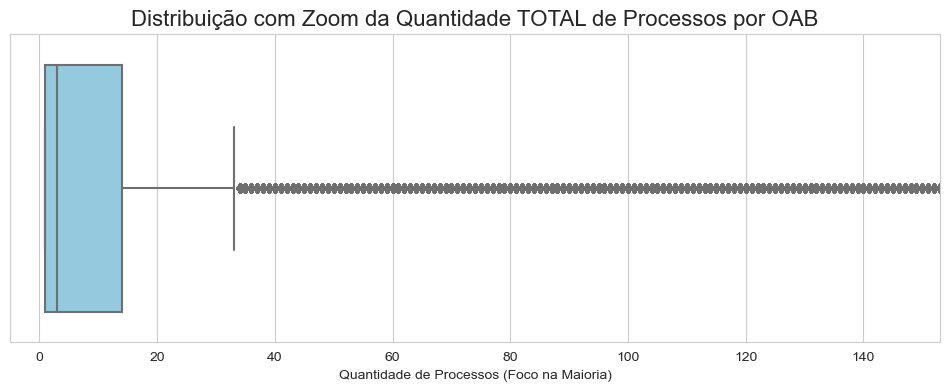


--- 6.2) An√°lise de Processos N√ÉO SIGILOSOS por OAB ---
Vis√£o completa da distribui√ß√£o dos processos n√£o sigilosos...


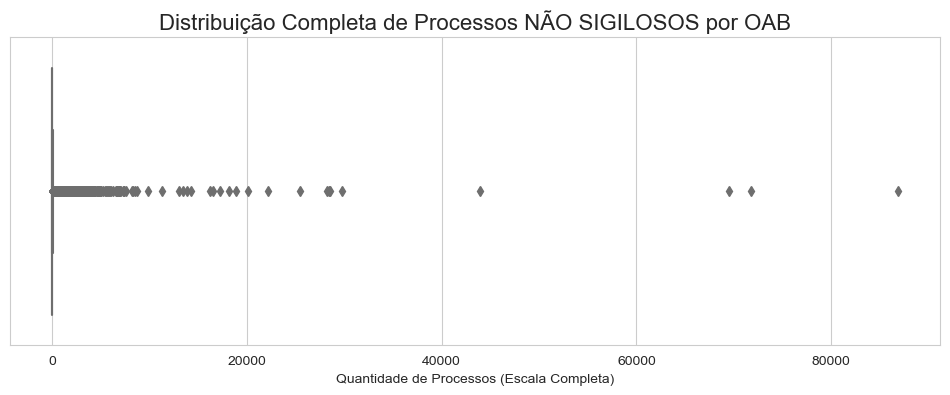


Zoom nos 95% dos advogados com menos processos n√£o sigilosos (at√© 117 processos)...


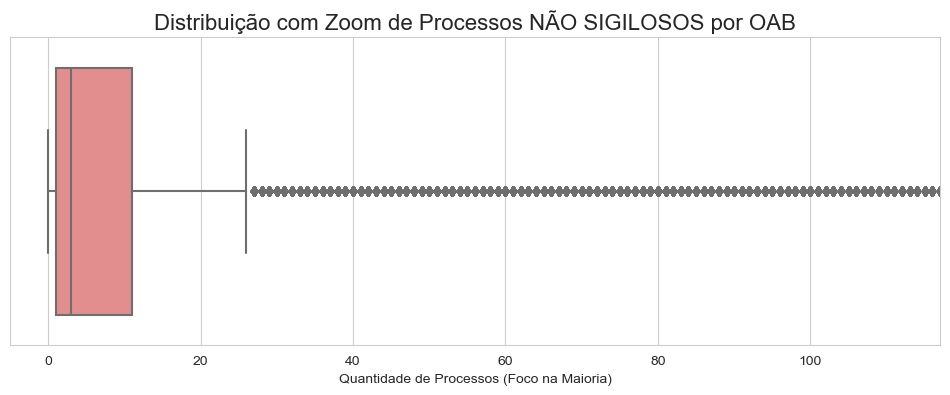


--- 6.3) An√°lise de Processos SIGILOSOS por OAB ---
Vis√£o completa da distribui√ß√£o dos processos sigilosos...


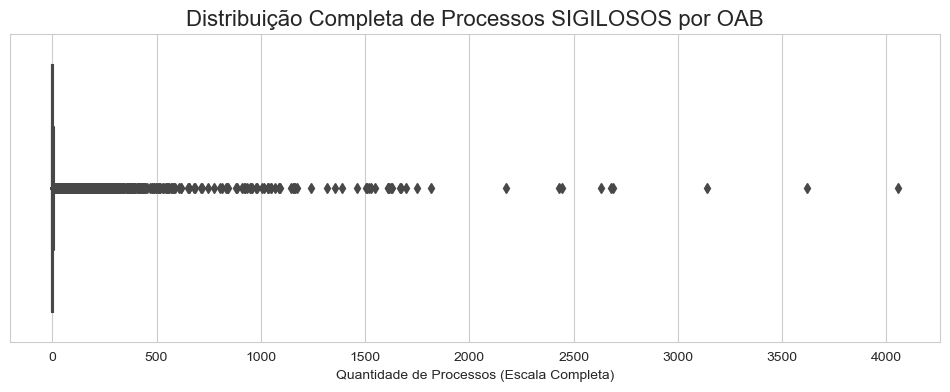


Zoom nos 95% dos advogados com menos processos sigilosos (at√© 29 processos)...


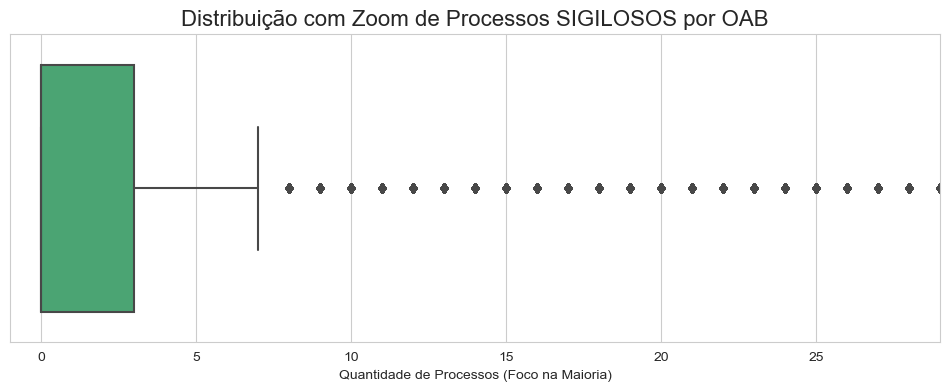

In [11]:
# 6) Visualiza√ß√£o Gr√°fica com Boxplots
print("\n" + "="*100)
print("=== VISUALIZA√á√ÉO DA DISTRIBUI√á√ÉO COM BOXPLOTS ===")
print("="*100 + "\n")

# --- 6.1) Boxplot Geral (Total de Processos) ---
print("--- 6.1) An√°lise Geral: Total de Processos por OAB ---")
print("Primeiro, a visualiza√ß√£o completa para entendermos a escala dos outliers...")

# Gr√°fico 1: Vis√£o completa
plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['total_processos'], color='skyblue')
plt.title('Distribui√ß√£o Completa da Quantidade TOTAL de Processos por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gr√°fico 2: Vis√£o com zoom
limite_zoom_geral = df_pivot_sorted['total_processos'].quantile(0.95)
print(f"\nAgora, um zoom na distribui√ß√£o, focando nos 95% dos advogados com menos processos (at√© {int(limite_zoom_geral)} processos)...")

plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['total_processos'], color='skyblue')
plt.title('Distribui√ß√£o com Zoom da Quantidade TOTAL de Processos por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-5, limite_zoom_geral)
plt.show()


# --- 6.2) Boxplot de Processos N√ÉO SIGILOSOS ---
print("\n" + "="*50)
print("--- 6.2) An√°lise de Processos N√ÉO SIGILOSOS por OAB ---")
print("Vis√£o completa da distribui√ß√£o dos processos n√£o sigilosos...")

# Gr√°fico 3: Vis√£o completa
plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['nao_sigilosos'], color='lightcoral')
plt.title('Distribui√ß√£o Completa de Processos N√ÉO SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gr√°fico 4: Vis√£o com zoom
limite_zoom_nao_sigilosos = df_pivot_sorted['nao_sigilosos'].quantile(0.95)
print(f"\nZoom nos 95% dos advogados com menos processos n√£o sigilosos (at√© {int(limite_zoom_nao_sigilosos)} processos)...")

plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['nao_sigilosos'], color='lightcoral')
plt.title('Distribui√ß√£o com Zoom de Processos N√ÉO SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-5, limite_zoom_nao_sigilosos)
plt.show()


# --- 6.3) Boxplot de Processos SIGILOSOS ---
print("\n" + "="*50)
print("--- 6.3) An√°lise de Processos SIGILOSOS por OAB ---")
print("Vis√£o completa da distribui√ß√£o dos processos sigilosos...")

# Gr√°fico 5: Vis√£o completa
plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['sigilosos'], color='mediumseagreen')
plt.title('Distribui√ß√£o Completa de Processos SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gr√°fico 6: Vis√£o com zoom
limite_zoom_sigilosos = df_pivot_sorted['sigilosos'].quantile(0.95)
if limite_zoom_sigilosos == 0:
    limite_zoom_sigilosos = 10 
print(f"\nZoom nos 95% dos advogados com menos processos sigilosos (at√© {int(limite_zoom_sigilosos)} processos)...")

plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['sigilosos'], color='mediumseagreen')
plt.title('Distribui√ß√£o com Zoom de Processos SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-1, limite_zoom_sigilosos)
plt.show()

# üìä Interpreta√ß√£o Visual dos Boxplots

Os gr√°ficos de boxplot confirmam visualmente a extrema concentra√ß√£o de processos em um pequeno n√∫mero de advogados.

### ‚öñÔ∏è 1. Distribui√ß√£o Total de Processos

* **üì¶ A Caixa (O Advogado T√≠pico):** A caixa azul, concentrada entre 0 e ~15 processos, mostra que 50% dos advogados atuam nesse baixo volume. A linha central (mediana) confirma que o advogado t√≠pico tem pouqu√≠ssimos casos.
* **‚ö´Ô∏è Os Outliers (Os Pontos Fora da Curva):** A longa sequ√™ncia de c√≠rculos que se estende at√© mais de 80.000 representa a minoria de advogados com um volume de trabalho imensamente superior √† maioria.
* **‚û°Ô∏è Conclus√£o:** A distribui√ß√£o √© altamente desigual. A enorme quantidade de outliers √© o que infla a m√©dia, que n√£o representa a realidade da maioria.

### üìñ 2. Distribui√ß√£o de Processos N√ÉO SIGILOSOS

* **üì¶ A Caixa:** O padr√£o √© quase id√™ntico ao gr√°fico geral. A grande maioria dos advogados possui um n√∫mero baixo de processos p√∫blicos (entre 0 e ~12).
* **‚ö´Ô∏è Os Outliers:** Novamente, uma pequena quantidade de advogados concentra a grande maioria dos processos n√£o sigilosos.
* **‚û°Ô∏è Conclus√£o:** Este tipo de processo √© o principal respons√°vel pela desigualdade observada na an√°lise geral, sendo o foco dos advogados de alto volume.

### üîí 3. Distribui√ß√£o de Processos SIGILOSOS

* **üì¶ A Caixa:** A caixa verde est√° "espremida" em zero. A linha da mediana em 0 √© a informa√ß√£o mais importante: **mais da metade dos advogados n√£o possui nenhum processo sigiloso**.
* **‚ö´Ô∏è Os Outliers:** Os advogados que atuam em casos sigilosos s√£o a exce√ß√£o. Aqueles com mais de ~8 casos j√° s√£o considerados outliers, indicando um nicho claro.
* **‚û°Ô∏è Conclus√£o:** Atuar em processos sigilosos √© uma **clara especializa√ß√£o**, n√£o sendo a norma para a maioria dos advogados na base de dados.

In [18]:
# 7) C√°lculo de Estat√≠sticas Descritivas (Medidas de Dispers√£o)
print("\n" + "="*100)
print("=== üî¨ AN√ÅLISE ESTAT√çSTICA DETALHADA DA DISPERS√ÉO DE PROCESSOS POR OAB ===")
print("="*100)

# Para evitar repeti√ß√£o de c√≥digo, criamos uma fun√ß√£o que calcula e imprime as m√©tricas
def calcular_e_imprimir_metricas(series, nome_grupo):
    """
    Calcula e imprime as m√©tricas de dispers√£o para uma S√©rie de dados.
    """
    print(f"\n--- {nome_grupo} ---")

    # 1. Amplitude: Diferen√ßa entre o valor m√°ximo e o m√≠nimo
    amplitude = series.max() - series.min()
    print(f"  - Amplitude: {amplitude:.2f}")
    print(f"    (Varia√ß√£o de {series.min()} a {series.max()} processos)")

    # 2. Desvio M√©dio Absoluto (MAD): M√©dia da dist√¢ncia de cada ponto at√© a m√©dia
    # O m√©todo .mad() foi descontinuado, esta √© a forma correta de calcular:
    media = series.mean()
    desvio_medio = (series - media).abs().mean()
    print(f"  - Desvio M√©dio Absoluto: {desvio_medio:.2f}")

    # 3. Vari√¢ncia: Medida da dispers√£o dos dados ao quadrado
    # Por padr√£o, o Pandas calcula a vari√¢ncia amostral (ddof=1), que √© a mais comum.
    variancia = series.var()
    print(f"  - Vari√¢ncia (amostral): {variancia:.2f}")

    # 4. Desvio Padr√£o: Raiz quadrada da vari√¢ncia, na mesma unidade dos dados
    desvio_padrao = series.std()
    print(f"  - Desvio Padr√£o (amostral): {desvio_padrao:.2f}")


# --- Chamada da fun√ß√£o para cada segmento ---

# An√°lise Geral
calcular_e_imprimir_metricas(df_pivot_sorted['total_processos'], "üìä An√°lise Geral (Total de Processos)")

# An√°lise de Processos N√£o Sigilosos
calcular_e_imprimir_metricas(df_pivot_sorted['nao_sigilosos'], "üìñ An√°lise de Processos N√ÉO SIGILOSOS")

# An√°lise de Processos Sigilosos
calcular_e_imprimir_metricas(df_pivot_sorted['sigilosos'], "üîí An√°lise de Processos SIGILOSOS")



=== üî¨ AN√ÅLISE ESTAT√çSTICA DETALHADA DA DISPERS√ÉO DE PROCESSOS POR OAB ===

--- üìä An√°lise Geral (Total de Processos) ---
  - Amplitude: 87277.00
    (Varia√ß√£o de 1.0 a 87278.0 processos)
  - Desvio M√©dio Absoluto: 63.79
  - Vari√¢ncia (amostral): 284952.96
  - Desvio Padr√£o (amostral): 533.81

--- üìñ An√°lise de Processos N√ÉO SIGILOSOS ---
  - Amplitude: 86839.00
    (Varia√ß√£o de 0.0 a 86839.0 processos)
  - Desvio M√©dio Absoluto: 55.03
  - Vari√¢ncia (amostral): 269603.21
  - Desvio Padr√£o (amostral): 519.23

--- üîí An√°lise de Processos SIGILOSOS ---
  - Amplitude: 4054.00
    (Varia√ß√£o de 0.0 a 4054.0 processos)
  - Desvio M√©dio Absoluto: 9.73
  - Vari√¢ncia (amostral): 1884.92
  - Desvio Padr√£o (amostral): 43.42


# üß† Interpreta√ß√£o dos Resultados da An√°lise de Dispers√£o

### 1. üìà Valores Elevados em Todas as M√©tricas (Geral e N√£o Sigilosos)
A grande **Amplitude**, **Vari√¢ncia** e **Desvio Padr√£o** confirmam o que foi observado nos boxplots: a distribui√ß√£o de processos √© extremamente dispersa. Os dados n√£o est√£o concentrados em torno da m√©dia. O alto **Desvio Padr√£o** significa que √© comum encontrar advogados com uma quantidade de processos muito distante da m√©dia.

### 2. üéØ Confirma√ß√£o dos Outliers
O **Desvio M√©dio Absoluto** alto refor√ßa essa ideia, indicando que, em m√©dia, a quantidade de processos de um advogado qualquer est√° muito longe da m√©dia geral. Isso √© um sintoma cl√°ssico de uma distribui√ß√£o com uma "cauda longa" de outliers (poucos advogados com muitos processos).

### 3. ‚öñÔ∏è Compara√ß√£o entre Sigilosos e N√£o Sigilosos
Os valores de dispers√£o para os processos **N√£o Sigilosos** s√£o drasticamente maiores do que para os **Sigilosos**. Isso demonstra que a extrema variabilidade no volume de trabalho dos advogados √© impulsionada principalmente pela atua√ß√£o em causas p√∫blicas.

### 4. üîí Dispers√£o no Nicho Sigiloso
Apesar de menores, as m√©tricas de dispers√£o para os processos **Sigilosos** ainda s√£o significativas em rela√ß√£o √† sua pr√≥pria m√©dia (que √© baixa). Isso sugere que, mesmo dentro desse nicho, existe uma desigualdade consider√°vel: h√° os especialistas que concentram os casos sigilosos e a maioria que atua esporadicamente ou nunca.

In [ ]:
# 8) C√°lculo do Coeficiente de Varia√ß√£o

print("\n" + "="*100)
print("=== üéØ C√ÅLCULO DO COEFICIENTE DE VARIA√á√ÉO (CV) ===")
print("="*100)
print("O Coeficiente de Varia√ß√£o mede a dispers√£o relativa dos dados. \nValores acima de 30% geralmente indicam uma alta variabilidade.\n")


def calcular_e_imprimir_cv(series, nome_grupo):
    """
    Calcula e imprime a m√©dia, o desvio padr√£o e o Coeficiente de Varia√ß√£o para uma S√©rie de dados.
    """
    print(f"--- {nome_grupo} ---")

    media = series.mean()
    desvio_padrao = series.std()

    # Evitar divis√£o por zero se a m√©dia for 0
    if media > 0:
        coeficiente_variacao = (desvio_padrao / media) * 100
        print(f"  - M√©dia:                 {media:.2f}")
        print(f"  - Desvio Padr√£o:         {desvio_padrao:.2f}")
        print(f"  - Coeficiente de Varia√ß√£o: {coeficiente_variacao:.2f}%")
    else:
        print(f"  - M√©dia:                 {media:.2f}")
        print(f"  - Desvio Padr√£o:         {desvio_padrao:.2f}")
        print("  - Coeficiente de Varia√ß√£o: N√£o pode ser calculado (m√©dia √© zero).")


# --- Chamada da fun√ß√£o para cada segmento ---

# 1. An√°lise Geral
calcular_e_imprimir_cv(df_pivot_sorted['total_processos'], "üìä An√°lise Geral (Total de Processos)")

# 2. An√°lise de Processos N√£o Sigilosos
calcular_e_imprimir_cv(df_pivot_sorted['nao_sigilosos'], "\nüìñ An√°lise de Processos N√ÉO SIGILOSOS")

# 3. An√°lise de Processos Sigilosos
calcular_e_imprimir_cv(df_pivot_sorted['sigilosos'], "\nüîí An√°lise de Processos SIGILOSOS")



=== üéØ C√ÅLCULO DO COEFICIENTE DE VARIA√á√ÉO (CV) ===
O Coeficiente de Varia√ß√£o mede a dispers√£o relativa dos dados. 
Valores acima de 30% geralmente indicam uma alta variabilidade.

--- üìä An√°lise Geral (Total de Processos) ---
  - M√©dia:                 43.27
  - Desvio Padr√£o:         533.81
  - Coeficiente de Varia√ß√£o: 1233.54%
--- 
üìñ An√°lise de Processos N√ÉO SIGILOSOS ---
  - M√©dia:                 36.71
  - Desvio Padr√£o:         519.23
  - Coeficiente de Varia√ß√£o: 1414.25%
--- 
üîí An√°lise de Processos SIGILOSOS ---
  - M√©dia:                 6.56
  - Desvio Padr√£o:         43.42
  - Coeficiente de Varia√ß√£o: 661.78%

=== üß† INTERPRETA√á√ÉO DOS RESULTADOS DO CV ===

1.  **Valores de CV Extremamente Altos:**
    Os Coeficientes de Varia√ß√£o para todos os grupos ser√£o muito altos (provavelmente na casa de centenas ou at√© milhares de porcento). Isso √© a prova estat√≠stica definitiva da **heterogeneidade extrema** da sua base de dados. Um CV t√£o ele

In [ ]:
# 9) An√°lise de Processos Baixados
# Usar uma c√≥pia para manter o original intacto.
df_analise_baixa = df_juridico.copy()

print("\n" + "="*100)
print("=== üìà AN√ÅLISE DE EFICI√äNCIA DE BAIXA (PROCESSOS SIGILOSOS VS. N√ÉO SIGILOSOS) ===")
print("="*100 + "\n")

# Prepara√ß√£o dos Dados
# -------------------------
# A coluna 'data_baixa' √© a chave. Se ela n√£o for nula, o processo foi baixado.
# Garantir que os tipos de dados estejam corretos.
df_analise_baixa['is_segredo_justica'] = df_analise_baixa['is_segredo_justica'].astype(bool)

# Criar uma coluna booleana 'processo_baixado' para facilitar os c√°lculos.
# .notna() retorna True para qualquer valor que n√£o seja nulo (ou seja, tem uma data de baixa).
df_analise_baixa['processo_baixado'] = df_analise_baixa['data_baixa'].notna()


# Segmenta√ß√£o dos Dados
# -------------------------
# Separar o DataFrame em dois: um para processos sigilosos e outro para n√£o sigilosos.
df_sigilosos = df_analise_baixa[df_analise_baixa['is_segredo_justica'] == True]
df_nao_sigilosos = df_analise_baixa[df_analise_baixa['is_segredo_justica'] == False]


# An√°lise de Processos N√ÉO SIGILOSOS
# ---------------------------------------
print("--- üìñ An√°lise de Processos N√ÉO SIGILOSOS ---")

total_nao_sigilosos = len(df_nao_sigilosos)
baixados_nao_sigilosos = df_nao_sigilosos['processo_baixado'].sum() # .sum() em booleanos conta os 'True'

if total_nao_sigilosos > 0:
    percentual_nao_sigilosos = (baixados_nao_sigilosos / total_nao_sigilosos) * 100
    print(f"Total de processos n√£o sigilosos: {total_nao_sigilosos}")
    print(f"Processos baixados (conclu√≠dos):   {baixados_nao_sigilosos}")
    print(f"‚û°Ô∏è Taxa de Baixa / Efici√™ncia:      {percentual_nao_sigilosos:.2f}%")
else:
    percentual_nao_sigilosos = 0
    print("N√£o foram encontrados processos n√£o sigilosos na base de dados.")


# An√°lise de Processos SIGILOSOS
# -----------------------------------
print("\n--- üîí An√°lise de Processos SIGILOSOS ---")

total_sigilosos = len(df_sigilosos)
baixados_sigilosos = df_sigilosos['processo_baixado'].sum()

if total_sigilosos > 0:
    percentual_sigilosos = (baixados_sigilosos / total_sigilosos) * 100
    print(f"Total de processos sigilosos: {total_sigilosos}")
    print(f"Processos baixados (conclu√≠dos): {baixados_sigilosos}")
    print(f"‚û°Ô∏è Taxa de Baixa / Efici√™ncia:     {percentual_sigilosos:.2f}%")
else:
    percentual_sigilosos = 0
    print("N√£o foram encontrados processos sigilosos na base de dados.")


# An√°lise de Efici√™ncia Global (Contribui√ß√£o para o Total)
# -------------------------------------------------------------
print("\n--- üìä An√°lise de Efici√™ncia Global (Contribui√ß√£o para o Total Geral) ---")

# O denominador agora √© a soma de TODOS os processos, sigilosos ou n√£o.
total_geral_processos = total_nao_sigilosos + total_sigilosos
print(f"Total geral de processos na base: {total_geral_processos}")

if total_geral_processos > 0:
    # C√°lculo: baixados n√£o sigilosos / (total sigilosos + total n√£o sigilosos)
    contrib_global_nao_sigilosos = (baixados_nao_sigilosos / total_geral_processos) * 100
    print(f"‚û°Ô∏è Contribui√ß√£o dos baixados N√ÉO SIGILOSOS para o total: {contrib_global_nao_sigilosos:.2f}%")

    # C√°lculo: baixados sigilosos / (total sigilosos + total n√£o sigilosos)
    contrib_global_sigilosos = (baixados_sigilosos / total_geral_processos) * 100
    print(f"‚û°Ô∏è Contribui√ß√£o dos baixados SIGILOSOS para o total:    {contrib_global_sigilosos:.2f}%")
else:
    print("N√£o h√° processos para calcular a efici√™ncia global.")


# Conclus√£o e Interpreta√ß√£o
# ------------------------------
print("\n" + "-"*50)
print("--- üéØ Conclus√£o da An√°lise ---")

if total_nao_sigilosos > 0 and total_sigilosos > 0:
    if abs(percentual_sigilosos - percentual_nao_sigilosos) < 1.0: # Diferen√ßa menor que 1%
        print("As taxas de baixa para processos sigilosos e n√£o sigilosos s√£o muito semelhantes.")
        print("Isso sugere que a natureza do processo (sigiloso ou n√£o) tem pouco impacto na sua velocidade de conclus√£o.")
    elif percentual_sigilosos > percentual_nao_sigilosos:
        diferenca = percentual_sigilosos - percentual_nao_sigilosos
        print(f"A taxa de baixa para processos SIGILOSOS √© {diferenca:.2f} pontos percentuais MAIOR.")
        print("Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de fam√≠lia), chegam a uma resolu√ß√£o mais rapidamente.")
        print("Um advogado poderia interpretar isso como uma √°rea de atua√ß√£o com um 'giro' mais r√°pido de casos.")
    else:
        diferenca = percentual_nao_sigilosos - percentual_sigilosos
        print(f"A taxa de baixa para processos N√ÉO SIGILOSOS √© {diferenca:.2f} pontos percentuais MAIOR.")
        print("Isso pode sugerir que processos p√∫blicos, talvez por serem mais padronizados, tramitam de forma mais eficiente no sistema judici√°rio.")
        print("Para um advogado, isso pode significar um retorno financeiro potencialmente mais previs√≠vel em volume.")
else:
    print("N√£o foi poss√≠vel realizar uma compara√ß√£o por falta de dados em uma das categorias.")

print("="*100)


=== üìà AN√ÅLISE DE EFICI√äNCIA DE BAIXA (PROCESSOS SIGILOSOS VS. N√ÉO SIGILOSOS) ===

--- üìñ An√°lise de Processos N√ÉO SIGILOSOS ---
Total de processos n√£o sigilosos: 4189374
Processos baixados (conclu√≠dos):   2674975
‚û°Ô∏è Taxa de Baixa / Efici√™ncia:      63.85%

--- üîí An√°lise de Processos SIGILOSOS ---
Total de processos sigilosos: 754977
Processos baixados (conclu√≠dos): 520138
‚û°Ô∏è Taxa de Baixa / Efici√™ncia:     68.89%

--- üìä An√°lise de Efici√™ncia Global (Contribui√ß√£o para o Total Geral) ---
Total geral de processos na base: 4944351
‚û°Ô∏è Contribui√ß√£o dos baixados N√ÉO SIGILOSOS para o total: 54.10%
‚û°Ô∏è Contribui√ß√£o dos baixados SIGILOSOS para o total:    10.52%

--------------------------------------------------
--- üéØ Conclus√£o da An√°lise ---
A taxa de baixa para processos SIGILOSOS √© 5.04 pontos percentuais MAIOR.
Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de fam√≠lia), chegam a uma resolu√ß√£o mai